# Tutorial 2 - Perceptron and logistic regression

In this tutorial, we'll introduce logistic regression and the percepron learning algorithm.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
import sklearn

## Binary classification

This section will introduce the specific context of binary classification, which is a sub-category of supervised learning. While the previous tutorial focused more on regression, where the model predicts a real-valued output $y \in \mathbb{R}$, this tutorial focuses on classification, where the model assigns the input into one of several classes. For binary classification, we formalize this as predicting one class from a finite set of two elements, typically $y \in \{0, 1\}$

### Generating synthetic data for classification

We will generate synthetic data points suitable for a two-class problem, ensuring the input vectors $\vec{x} \in \mathbb{R}^d$ and corresponding labels $y \in \{0, 1\}$ are created.

In [2]:
X, y = make_classification(
    n_samples = 100,
    n_features = 2,
    n_redundant = 0,
    n_informative = 2,
    n_classes = 2,
    random_state = 42
)

print("Input shape X:", X.shape)
print("Output shape y:", y.shape)

Input shape X: (100, 2)
Output shape y: (100,)


Let's visualize the generated data:

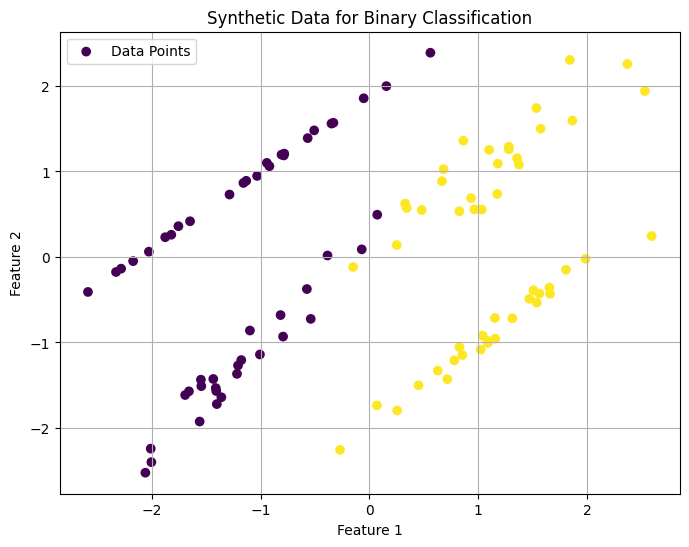

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c = y, marker = 'o', label = 'Data Points')
plt.title('Synthetic Data for Binary Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.legend()
plt.show()

## A logistic regression model

Logistic regression is an improvement over linear regression. Whereas linear regression could only fit linear functions for regression, logistic regression augments it with a nonlinearity making it suitable for classification.

In linear regression, the relationship is defined by a simple dot product: $\hat{y} = \vec{x}^T \vec{w} + b$. Logistic regression uses a similar linear combination but passes the result through a sigmoid (logistic) function:

$$ f ( x ) = \frac{x}{1 + e^{-x}} $$

This function is used to map the output to a probability between 0 and 1, suitable for classification.

### Cost function

In contrast to linear regression, which typically uses the Mean Square Error (MSE) cost function, classification models use cost functions better suited for probability outputs. For binary classification, the standard cost function is the Binary Cross-Entropy (or Log Loss).

In [4]:
def binary_cross_entropy(y_true, y_pred_proba):
    # Ensure clipping to avoid log(0)
    epsilon = 1e-12
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1. - epsilon)
    # Log Loss calculation
    return -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))

### Implementation and visualization of a decision strategy

The output of logistic regression is a probability $\hat{p}$. The decision strategy is a threshold applied to this probability to assign a final class label (0 or 1). Typically, if $\hat{p} \geq 0.5$, the prediction is class 1; otherwise, it is class 0. The boundary where $\hat{p} = 0.5$ is called the decision boundary.

In [5]:
def plot_decision_boundary(model, X, y):    
    # Setup the limits and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create coordinate matrices for the plot grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict class labels for every point on the meshgrid    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
    
    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.show()

### Training logistic regression with scikit-learn

We will use the `scikit-learn` library to train the logistic regression model:

In [6]:
model = LogisticRegression() 
model.fit(X, y)
y_pred_optimal_proba = model.predict_proba(X)[:, 1] # Get probabilities for class 1
optimal_cost = binary_cross_entropy(y, y_pred_optimal_proba)

print("Optimal cost (BCE) after training:", optimal_cost)

Optimal cost (BCE) after training: 0.0905222574854022


Let's also visualize the learned decision boundary:

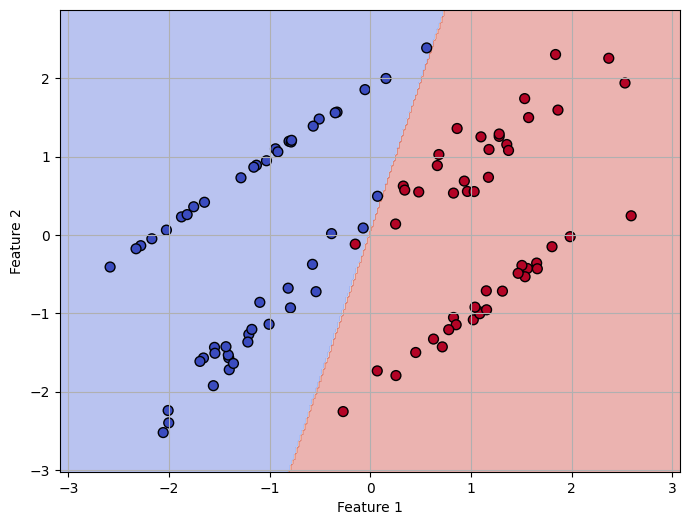

In [7]:
plot_decision_boundary(model, X, y) 

## Evaluating the Model

For classification, evaluation focuses on metrics like accuracy, precision, and recall, rather than just MSE or $R^2$ which are typically used for regression.

In [8]:
y_pred_classes = model.predict(X)
acc = accuracy_score(y, y_pred_classes)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9900


### Task 1: Manual logistic regression

Train a logistic regression model using gradient descent on BCE cost function.

In [9]:
class ManualLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.W = None
        self.b = None

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        
        # Initialize parameters
        self.W = np.zeros(n_features) 
        self.b = 0
        
        # Gradient Descent loop
        for epoch in range(self.epochs):
            
            # Forward Pass
            linear_output = np.dot(X_train, self.W) + self.b
            
            # Get probabilities (y_hat)
            y_pred_proba = self._sigmoid(linear_output)
            
            # Backward Pass: Calculate Gradients
            # Error used for update: (y_hat - y)
            error = y_pred_proba - y_train
            
            # Gradient for weights (dW)
            dW = (1 / n_samples) * np.dot(X_train.T, error)
            
            # Gradient for bias (db)
            db = (1 / n_samples) * np.sum(error)
            
            # Update Parameters
            self.W = self.W - self.learning_rate * dW
            self.b = self.b - self.learning_rate * db
        
        return self

    def predict_proba(self, X_input):
        linear_output = np.dot(X_input, self.W) + self.b
        return self._sigmoid(linear_output)

    def predict(self, X_input):
        probabilities = self.predict_proba(X_input)
        return (probabilities >= 0.5).astype(int)

In [10]:
model = ManualLogisticRegression() 
model.fit(X, y)
y_pred_optimal_proba = model.predict_proba(X)
optimal_cost = binary_cross_entropy(y, y_pred_optimal_proba)

print("Optimal cost (BCE) after training:", optimal_cost)

Optimal cost (BCE) after training: 0.1701260417468654


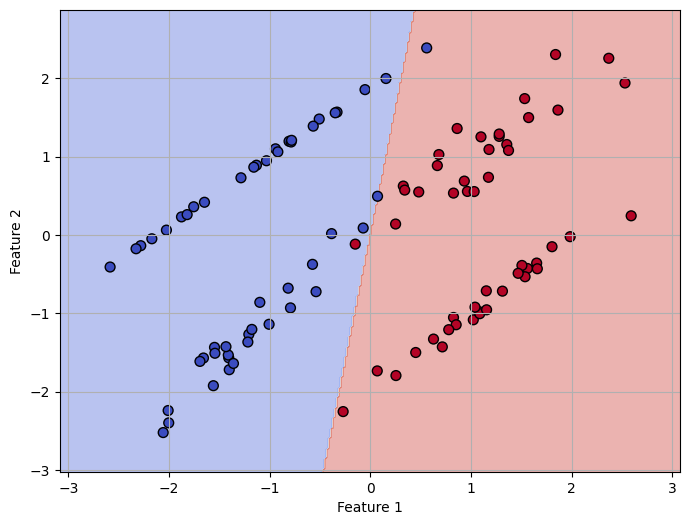

In [11]:
plot_decision_boundary(model, X, y) 

Let's again also look at the accuracy:

In [12]:
y_pred_classes = model.predict(X)
acc = accuracy_score(y, y_pred_classes)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9700


## The perceptron model

The perceptron is an earlier, foundational algorithm for linear binary classification. In essence, it's a simple algorithm that mimics a single neuron in the human brain, capable of making basic decisions and, crucially, learning from its mistakes.

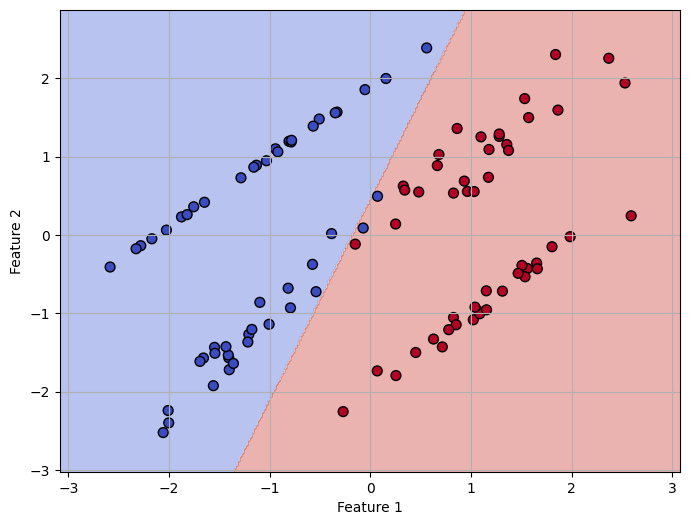

In [13]:
model = Perceptron()
model.fit(X, y)
plot_decision_boundary(model, X, y)

### Perceptron learning algorithm and implementation

The perceptron operates by adjusting weights based on misclassified points. It does this through a process called the *Perceptron Learning Algorithm*, which is a form of supervised learning. This means we provide the perceptron with training data that includes both the inputs and the correct outputs. The perceptron then adjusts its weights and bias to make its predictions more accurate.
- Initialization: The perceptron starts with random values for its weights and bias.
- Prediction: It takes an example from the training data and makes a prediction based on its current weights and bias.
- Error Calculation: The perceptron's prediction is compared to the correct output from the training data. The difference between the two is the error.
- Weight and Bias Update: This is the crucial learning step.
    - If the prediction is correct: The weights and bias are not changed.
    - If the prediction is incorrect: The weights and bias are adjusted to reduce the error. The update rule is simple: the change in a weight is proportional to the error and the input it's associated with. A small value called the "learning rate" controls how much the weights and bias are adjusted in each step.

$$ w_{i, t} = w_{i, t-1} + \eta ( y_i - \hat{y_i} ) \vec{x}_i $$

- Iteration: This process of predicting, calculating the error, and updating the weights is repeated for all the examples in the training data, multiple times. With each pass through the data (called an "epoch"), the perceptron's weights and bias get closer to the optimal values that allow it to make correct predictions.

### Task 2

Create a manual perceptron model.

In [14]:
class ManualPerceptron:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            for x_i, y_i in zip(X, y):
                
                # Calculate the linear combination
                linear_output = np.dot(x_i, self.weights) + self.bias
                
                # Apply the activation function (Heaviside step function) ---
                y_pred = 1 if linear_output >= 0 else 0
                
                # Calculate the error
                error = y_i - y_pred
                
                # -Apply the Perceptron Update Rule
                if error != 0:
                    update = self.learning_rate * error
                    self.weights += update * x_i
                    
                    # Update bias: b_new = b_old + learning_rate * error
                    self.bias += update

    def predict(self, X_input):
        linear_output = np.dot(X_input, self.weights) + self.bias
        y_pred = np.where(linear_output >= 0, 1, 0)
        
        return y_pred

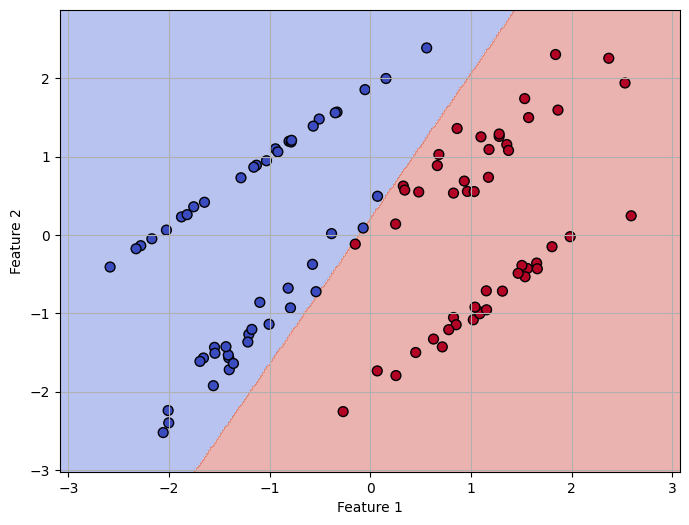

In [15]:
model = ManualPerceptron()
model.fit(X, y)
plot_decision_boundary(model, X, y)

In [16]:
y_pred_classes = model.predict(X)
acc = accuracy_score(y, y_pred_classes)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 1.0000
